### IT2TSK Gaussian Explorer

In [1]:
from notebook_resolver import *
from src.utils.pandas_extension import *
from src.dataset import Dataset, WorkSheet

dataset_path = "data/e-nose_dataset_12_beef_cuts.xlsx"

worksheet_name = WorkSheet.DS8.value

dataset = Dataset(
	path=dataset_path, sheet_name=worksheet_name, skip_columns=["Minute","Label"]
)

train_df = dataset.train_df
test_df = dataset.validate_df # we should not use test_df for training


In [2]:

from sklearn.metrics import r2_score
from src.pipeline import Pipeline
from src.pipelines.transformers import FeatureScaler, FeatureSelector

from src.pipelines.predictors import IT2TskPredictor
from src.fis.fuzzy_logic.mfs import MFType2
from src.fis.fuzzy_logic.consequents import LinearModel
from src.clusters import ClusteringMethod

target_column = 'TVC'
batch = 1024
tol = 0.00001
max_no_improvement = 5

pipeline = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	('feature_selection', FeatureSelector()),
	('predictor', IT2TskPredictor(target=target_column))
])

pipeline.fit(
    train_df,
    predictor__clustering_method=ClusteringMethod.MBKMEANS,
	predictor__mfs__cluster__batch_size=batch,
	predictor__mfs__cluster__tol=tol,
	predictor__mfs__cluster__max_no_improvement=max_no_improvement,  # Fixed for simplicity
	predictor__rules__cluster__batch_size=batch,
	predictor__rules__cluster__tol=tol,
	predictor__rules__cluster__max_no_improvement=max_no_improvement, 
	predictor__mf_type=MFType2.GAUSSIAN,
    predictor__linear_model=LinearModel.LSE
)

transformed_test_df = pipeline.transform(test_df)
X_test_df = transformed_test_df.drop(columns=[target_column])

y_test_ = transformed_test_df[target_column].values
y_pred_ = pipeline.predict(X_test_df)

r2 = r2_score(y_test_, y_pred_)
print(f"R2 Score on Test Data: {r2}")

R2 Score on Test Data: 0.9944930183808317


In [3]:
selector = pipeline.named_steps['feature_selection']
selector.correlation_scores_

[{'MQ4': 0.97},
 {'MQ136': 0.97},
 {'MQ8': 0.95},
 {'MQ138': 0.9},
 {'MQ3': 0.71},
 {'MQ135': 0.68},
 {'MQ9': 0.4},
 {'MQ2': 0.33},
 {'MQ6': 0.79},
 {'MQ137': 0.8},
 {'MQ5': 0.9}]

In [4]:
predictor = pipeline.named_steps["predictor"]

In [5]:
predictor.get_lt_rules()

+--------+-----------+------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Rule   | Cluster   | IF (Antecedents)                         | THEN (Consequents)                                                                                                                                                          |
+========+===========+==========================================+=============================================================================================================================================================================+
| Rule 1 | Cluster 0 | MQ4 is Low AND MQ136 is Low AND MQ8 is   | TVC is 0.8571 + 0.945*MQ4 + 0.0446*MQ136 + 0.004*MQ8 + -0.228*MQ138 + -0.1435*MQ3 + 0.0013*MQ135 + -0.0053*MQ9 + 0.0007*MQ2 + -0.02*MQ6 + 0.1503*MQ137 + 0.0172*MQ5         |
|        |           | Low AND MQ138 is 

,Rule,Cluster,IF (Antecedents),THEN (Consequents)
0,Rule 1,Cluster 0,MQ4 is Low AND MQ136 is Low AND MQ8 is Low AND...,TVC is 0.8571 + 0.945*MQ4 + 0.0446*MQ136 + 0.0...
1,Rule 2,Cluster 1,MQ4 is Medium AND MQ136 is Low AND MQ8 is Low ...,TVC is 0.7574 + -0.7432*MQ4 + -0.355*MQ136 + -...
2,Rule 3,Cluster 2,MQ4 is High AND MQ136 is High AND MQ8 is High ...,TVC is 0.8837 + -0.0842*MQ4 + -0.4767*MQ136 + ...


In [6]:
predictor.clusters_.get_execution_time_stats('_create_mfs_clusters')

{'count': 1,
 'total_time': 3.9279525830061175,
 'average_time': 3.9279525830061175,
 'min_time': 3.9279525830061175,
 'max_time': 3.9279525830061175}

In [7]:
predictor.clusters_.get_execution_time_stats('_create_rules_cluster')

{'count': 1,
 'total_time': 0.36028937494847924,
 'average_time': 0.36028937494847924,
 'min_time': 0.36028937494847924,
 'max_time': 0.36028937494847924}

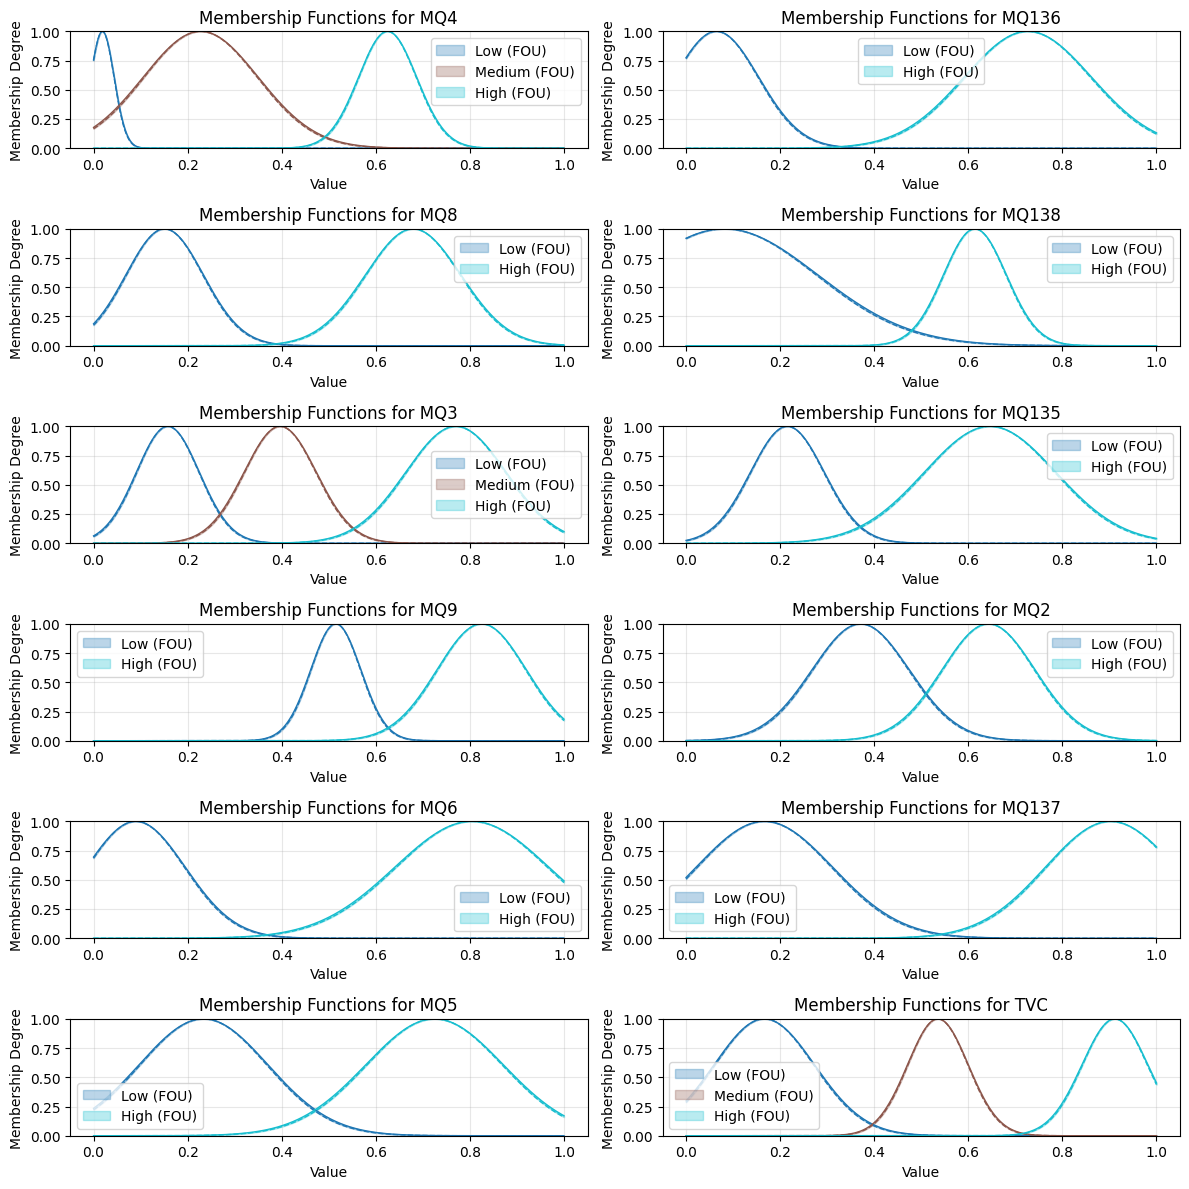

In [8]:
predictor.plot_mfs_grid()

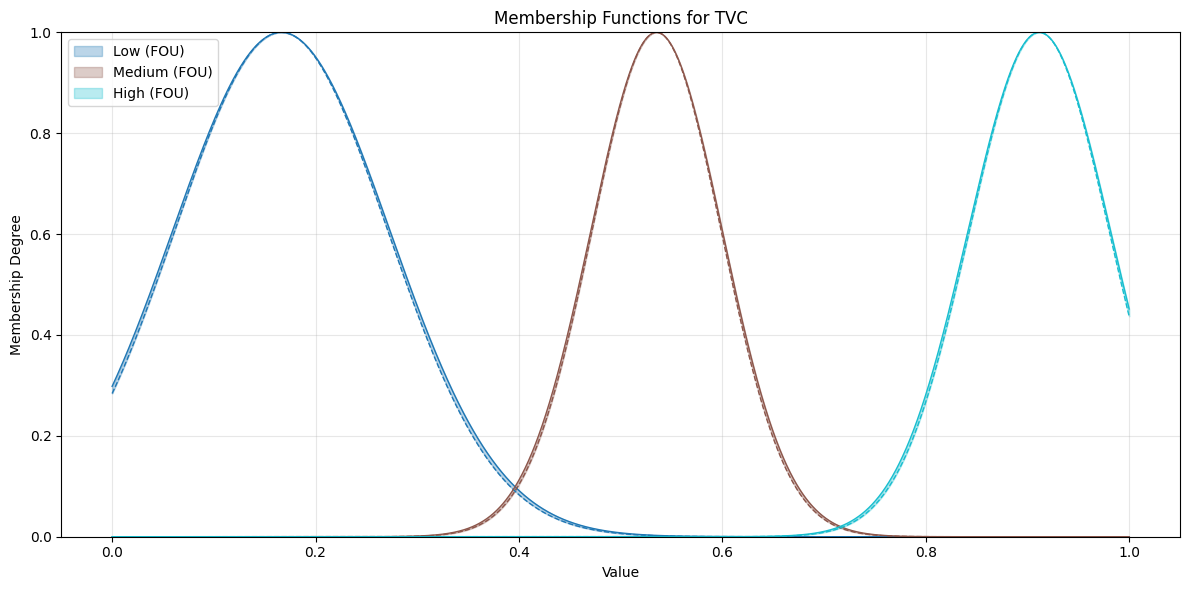

In [9]:
predictor.plot_mf('TVC')

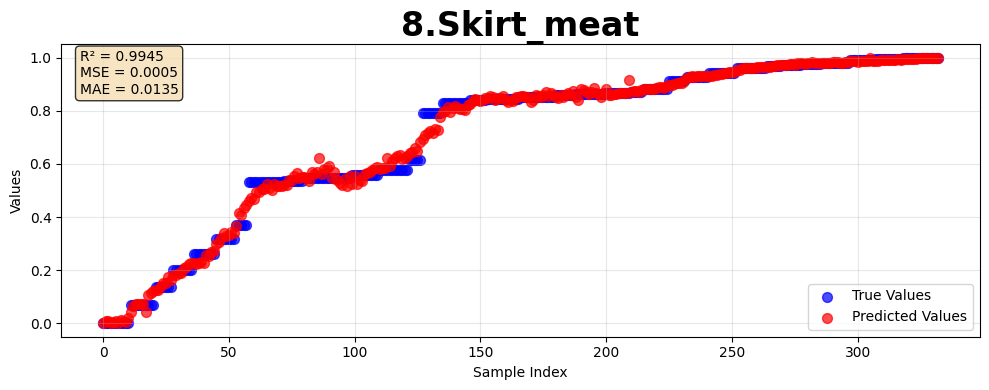

In [10]:
predictor.plot_true_vs_pred(y_test_, y_pred_, title=f"{worksheet_name}")